C:\Users\donye\OneDrive\Desktop\WPI\GRAD\Data Mining\Project 3\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset...
Splitting data...
Training models in parallel...
Model training and evaluation completed. This is the Vanilla Model{}
(202944, 21)
(50736, 21)
Tuning Random Forest...
Random Forest tuning completed.
Tuning Decision Tree...
Decision Tree tuning completed.
Tuning Gradient Boosting...
Gradient Boosting tuning completed.
Tuning KNN Regressor...
KNN tuning completed.
Performing cross-validation...
Cross-validation completed. MSE scores - RandomForest: 0.43085996352988715, DecisionTree: 0.8187496690127819, GradientBoosting: 0.39021833554523866, LinearRegression: 0.40426308944622064, KNN: 0.4693426561206623
Plotting results...


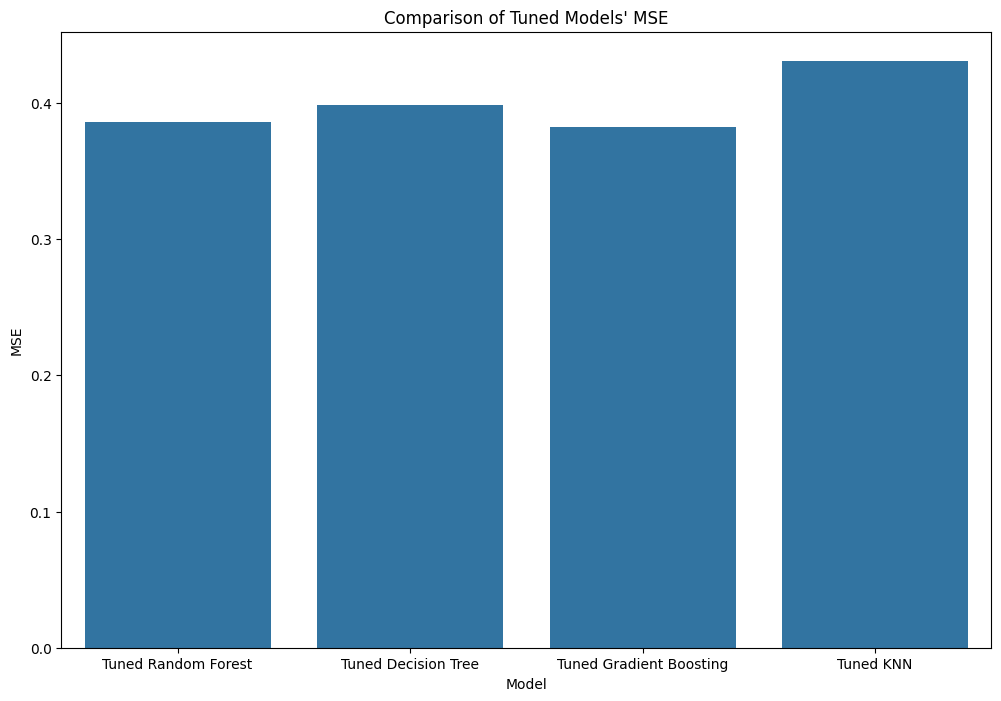

Final model results:
               Model       MAE       MSE      RMSE        R2
0  Linear Regression  0.442539  0.399754  0.632261  0.173310
1      Random Forest  0.424123  0.426881  0.653361  0.117211
2  Gradient Boosting  0.404781  0.384177  0.619820  0.205522
3      KNN Regressor  0.403433  0.469012  0.684845  0.030083
4      Decision Tree  0.427019  0.805501  0.897497 -0.665775


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV
import numpy as np
import shap
import lime
import lime.lime_tabular

%matplotlib inline

pth = 'diabetes_012_health_indicators_BRFSS2015.csv'
print("Loading dataset...")
df = pd.read_csv(pth)

# Splitting data
X = df.drop(columns='Diabetes_012')
y = df['Diabetes_012']
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor()
}

vanilla_mse = {}

# Function to train and evaluate each model
def train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"Training {name} model...")
    model.fit(X_train, y_train)


    print(f"{name} training completed. Evaluating...")

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    vanilla_mse[name] = mse
    print(f"{name} evaluation completed.")

    return {
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2_score(y_test, y_pred)
    }

# Parallel training of models
print("Training models in parallel...")
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate_model)(name, model, X_train, y_train, X_test, y_test)
    for name, model in models.items()
)
print(f"Model training and evaluation completed. This is the Vanilla Model{vanilla_mse}")

# Optimizing with GridSearchCV
optimized_mse = {}
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xtrain_scale, Xtest_scale, Ytrain_scaled, Ytest_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(Xtrain_scale.shape)  # Shape during training
print(Xtest_scale.shape)   # Shape passed to SHAP

# Random Forest
print("Tuning Random Forest...")
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [10, None]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xtrain_scale, Ytrain_scaled)
y_pred_rf = grid_rf.predict(Xtest_scale)
optimized_mse["Tuned Random Forest"] = mean_squared_error(Ytest_scaled, y_pred_rf)
print("Random Forest tuning completed.")

# Decision Tree
print("Tuning Decision Tree...")
param_grid_dt = {'max_depth': [5, 10, None]}
grid_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xtrain_scale, Ytrain_scaled)
y_pred_dt = grid_dt.predict(Xtest_scale)
optimized_mse["Tuned Decision Tree"] = mean_squared_error(Ytest_scaled, y_pred_dt)
print("Decision Tree tuning completed.")

# Gradient Boosting
print("Tuning Gradient Boosting...")
param_grid_gb = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 7],'subsample': [0.8, 1.0]}
grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gb.fit(Xtrain_scale, Ytrain_scaled)
y_pred_gb = grid_gb.predict(Xtest_scale)
optimized_mse["Tuned Gradient Boosting"] = mean_squared_error(Ytest_scaled, y_pred_gb)
print("Gradient Boosting tuning completed.")

# KNN Regressor
print("Tuning KNN Regressor...")
param_grid_knn = {'n_neighbors': [3, 5, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_knn.fit(Xtrain_scale, Ytrain_scaled)
y_pred_knn = grid_knn.predict(Xtest_scale)
optimized_mse["Tuned KNN"] = mean_squared_error(Ytest_scaled, y_pred_knn)
print("KNN tuning completed.")

# # Cross-validation scores for all models
print("Performing cross-validation...")
cv_rf = cross_val_score(RandomForestRegressor(), Xtrain_scale, Ytrain_scaled, cv=5, scoring='neg_mean_squared_error')
cv_dt = cross_val_score(DecisionTreeRegressor(), Xtrain_scale, Ytrain_scaled, cv=5, scoring='neg_mean_squared_error')
cv_gb = cross_val_score(GradientBoostingRegressor(), Xtrain_scale, Ytrain_scaled, cv=5,scoring='neg_mean_squared_error')
cv_lr = cross_val_score(LinearRegression(), Xtrain_scale, Ytrain_scaled, cv=5, scoring='neg_mean_squared_error')
cv_knn = cross_val_score(KNeighborsRegressor(), Xtrain_scale, Ytrain_scaled, cv=5, scoring='neg_mean_squared_error')

print(
    f"Cross-validation completed. MSE scores - RandomForest: {-cv_rf.mean()}, "
    f"DecisionTree: {-cv_dt.mean()}, "
    f"GradientBoosting: {-cv_gb.mean()}, "
    f"LinearRegression: {-cv_lr.mean()}, "
    f"KNN: {-cv_knn.mean()}")

# print(
#     f"Cross-validation completed. MSE scores - LinearRegression: {-cv_lr.mean()}, "
#     f"KNN: {-cv_knn.mean()}")


an_LN_model = LinearRegression()
an_LN_model.fit(Xtrain_scale, Ytrain_scaled)

# Plotting optimized MSE
print("Plotting results...")
optimized_df = pd.DataFrame(list(optimized_mse.items()), columns=['Model', 'MSE'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='MSE', data=optimized_df)
plt.title("Comparison of Tuned Models' MSE")
plt.show()

results_df = pd.DataFrame(results)
print("Final model results:")
print(results_df)

In [2]:

# Create LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain_scale,
                                                   feature_names=X.columns,
                                                   class_names=['Diabetes_012'],
                                                   verbose=True,
                                                   mode='regression',
                                                   random_state=42)

# Explain a single instance from the test set (e.g., first instance)
instance_to_explain = Xtest_scale[0].reshape(1, -1)

# KNN Regressor LIME Explanation (First Plot Below Here)
print("Creating LIME explanation for KNN Regressor...")
lime_exp_knn = explainer.explain_instance(Xtest_scale[0], grid_knn.predict)
lime_exp_knn.show_in_notebook()
lime_exp_knn.save_to_file('lime_knn_explanation.html')

# Linear Regression LIME Explanation (Second Plot Below Here)
print("Creating LIME explanation for Linear Regression...")
lime_exp_lr = explainer.explain_instance(Xtest_scale[0], an_LN_model.predict)
lime_exp_lr.show_in_notebook()
lime_exp_lr.save_to_file('lime_lr_explanation.html')

Creating LIME explanation for KNN Regressor...
Intercept 0.788000292343002
Prediction_local [0.2234046]
Right: 0.0


Creating LIME explanation for Linear Regression...
Intercept 0.6153456453242955
Prediction_local [0.26999705]
Right: 0.14698525619599692


Creating SHAP explainer for Gradient Boosting...
Computing SHAP values for Gradient Boosting...


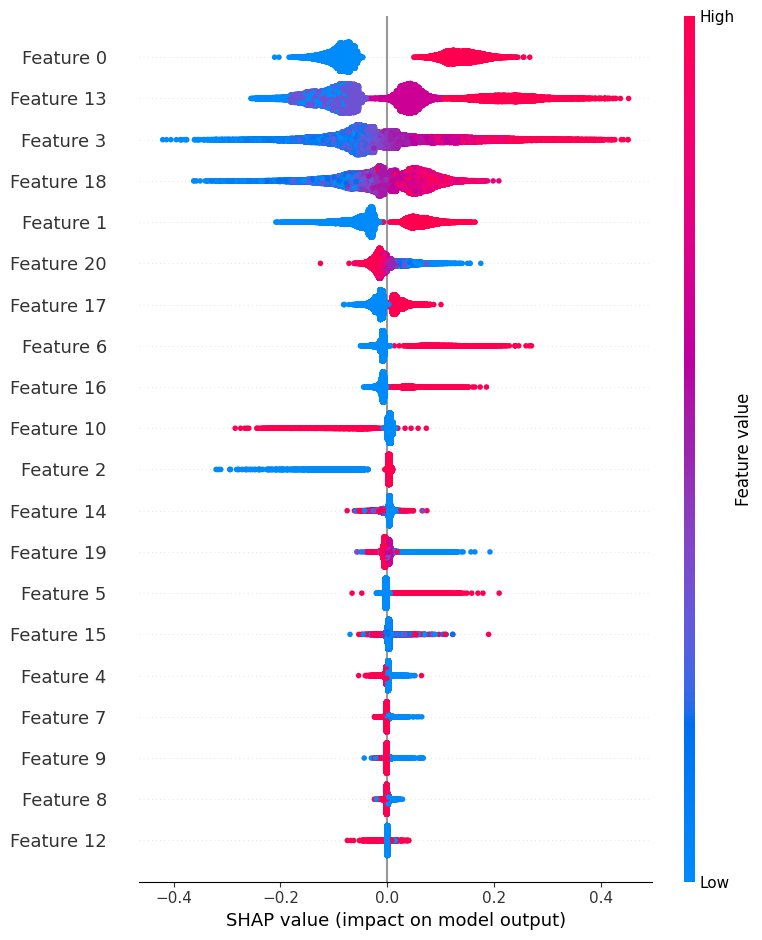

Creating SHAP explainer for Random Forest...
Computing SHAP values for Random Forest...


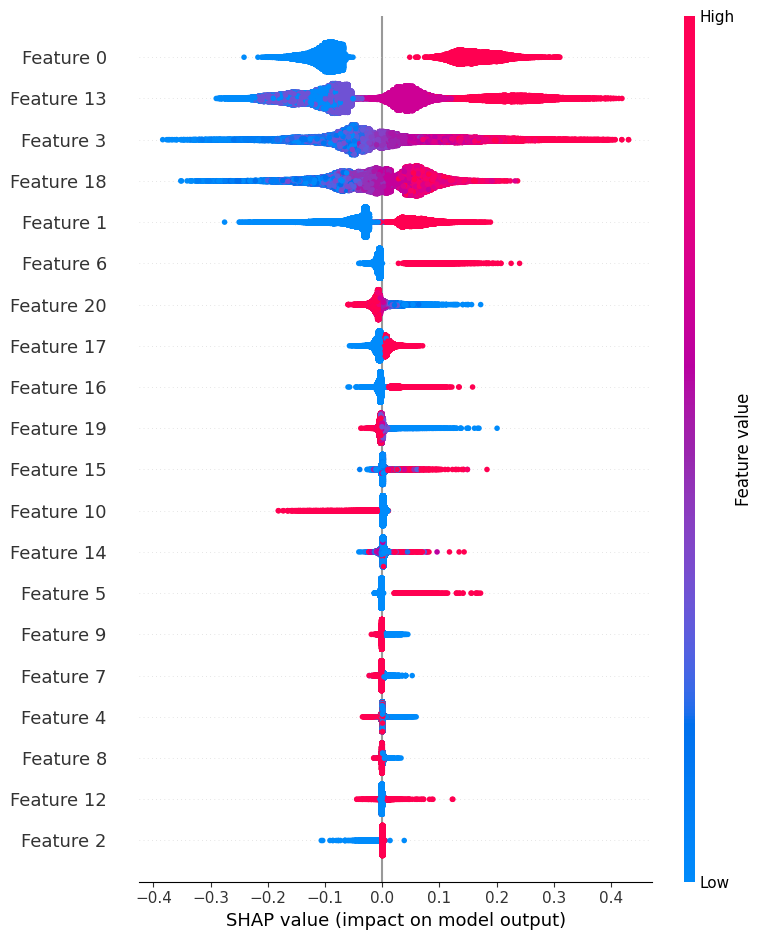

Creating SHAP explainer for Decision Tree...
Computing SHAP values for Decision Tree...


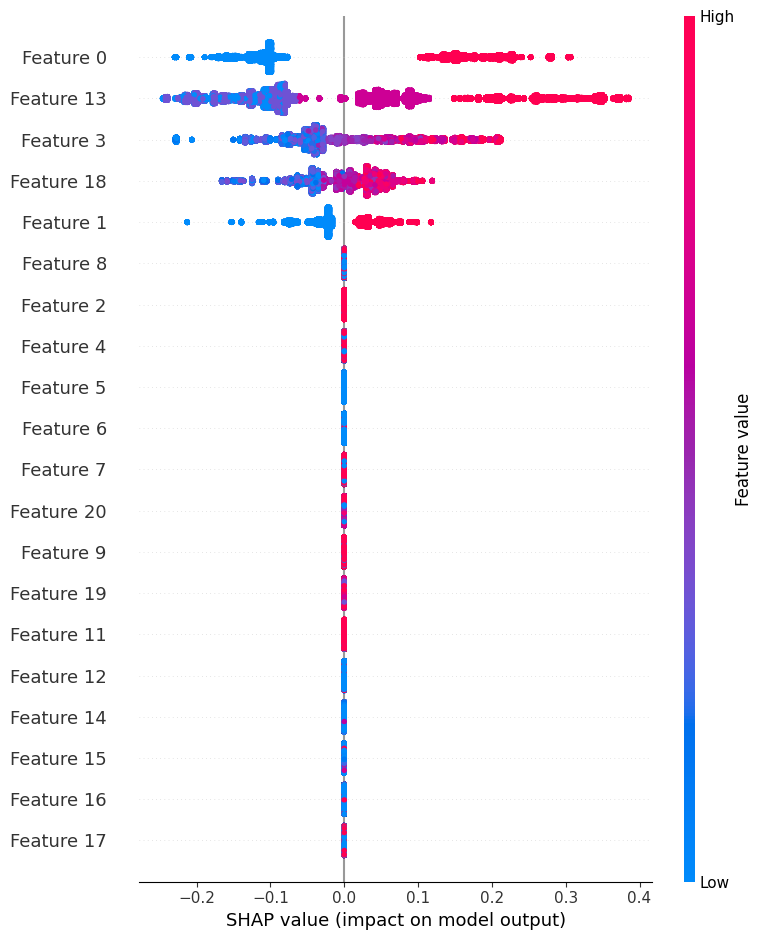

In [3]:
# Making RF Explainer
print("Creating SHAP explainer for Random Forest...")
shap_explainer_rf = shap.TreeExplainer(grid_rf.best_estimator_)

print("Computing SHAP values for Random Forest...")
shap_values_rf = shap_explainer_rf.shap_values(Xtest_scale)

shap.summary_plot(shap_values_rf, Xtest_scale, show=False)
plt.title("RF Feature Impact Plot")
plt.show()



# Making DT Explainer
print("Creating SHAP explainer for Decision Tree...")
shap_explainer_dt = shap.TreeExplainer(grid_dt.best_estimator_)

print("Computing SHAP values for Decision Tree...")
shap_values_dt = shap_explainer_dt.shap_values(Xtest_scale)

shap.summary_plot(shap_values_dt, Xtest_scale, show=False)
plt.title("DT Feature Impact Plot")
plt.show()